In [109]:
import numpy as np
import pandas as pd

file_paths = [
    "Måling/PlutoK.csv",
    "Måling/PlutoM.csv"]

RBW = 100 # Hz
VBW = 1000 # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = {}
keys = ['PlutoK', 'PlutoM']
spektrum = {key: pd.DataFrame() for key in keys}
for file_path, key in zip(file_paths, keys):
    spektrum[key] = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
    spektrum[key]['Frequency[GHz]'] = spektrum[key]['Frequency[Hz]'] / 1e9
    spektrum[key]['Power [dBW]'] = spektrum[key]['Power [dBW]'] + 30 # Attenuator + 30 dB

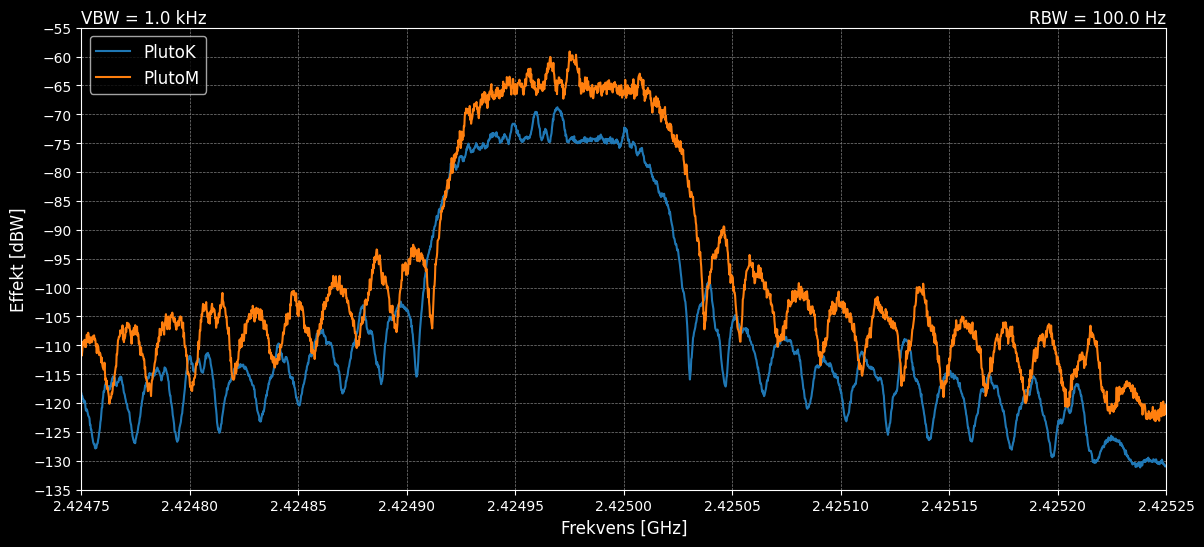

In [110]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')


colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14, 6))
for key, color in zip(keys, colors):
    plt.plot(spektrum[key]['Frequency[GHz]'], spektrum[key]['Power [dBW]'], linestyle='-', color=color, label=key)

plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right')
plt.annotate('VBW = {:.1f} kHz'.format(VBW/1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left')

plt.xticks(np.arange(2.42475, 2.42525, 0.00005))
plt.yticks(np.arange(-135, -54, 5))
plt.xlim(2.42475, 2.42525)
plt.ylim(-135, -55)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.savefig('Figurer/PlutoSpektrum.pdf', bbox_inches='tight')
plt.show()